In [2]:
import numpy as np
import spacy
import random 
import pandas as pd
from tqdm import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd




In [3]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anilk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anilk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df=pd.read_csv('canadian_banks_reddit_posts_2024_09_26-22_42_07.csv')

In [5]:
ALPHA=0.1
BETA=0.1
NUM_TOPICS=10
sp=spacy.load('en_core_web_sm')
np.random.seed(42)
random.seed(42)


In [10]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'\W', ' ', text)
    
    # Tokenize the text
    words = text.split()
    
    # Create a new list for lemmatized words
    lemmatized_words = []
    
    # Remove stop words and lemmatize
    for word in words: 
        if word not in stop_words and word.isalpha():
            lemmatized_word = lemmatizer.lemmatize(word)
            lemmatized_words.append(lemmatized_word)
    
    # Join lemmatized words back into a string
    return ' '.join(lemmatized_words)

# Apply preprocessing to each row in the dataframe
for index, row in df.iterrows():
    text = row['Selftext']
    cleaned_text = preprocess_text(text)
    df.loc[index, 'cleaned_text'] = cleaned_text

# Save the updated dataframe to CSV
df.to_csv('cleaned_output_file_oct.csv', index=False)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize CountVectorizer (Bag of Words)
vectorizer = CountVectorizer(max_df=0.9,min_df=2,stop_words='english')
df=pd.read_csv('cleaned_output_file_oct.csv')
# Remove rows where 'cleaned_text' is NaN
df = df.dropna(subset=['cleaned_text'])
#Apply CountVectorizer on cleaned_text column to get dtm (Document Term Matrix)
dtm=vectorizer.fit_transform(df['cleaned_text'])
# store the DTM in a new DataFrame
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
# Save the DTM to a CSV file
dtm_df.to_csv('dtm_output_oct.csv', index=False)

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

# Assuming dtm is your document-term matrix (from CountVectorizer)
n_topics = 10  # Number of topics you expect

# Initialize the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Fit the LDA model to the document-term matrix
lda_model.fit(dtm)

LatentDirichletAllocation(random_state=42)

In [14]:
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, 10)  # Display top 10 words per topic

Topic 1:
bank td account money customer know time got transfer branch
Topic 2:
corp schwab stock corporation holding docn answer growth technology company
Topic 3:
card bank credit rate point rbc plc fee visa year
Topic 4:
buy hold mp op sp netflix content market sub capital
Topic 5:
account bank td money transfer payment fee bmo saving need
Topic 6:
card credit day number account bank said td time bmo
Topic 7:
fund etf http stock com investing www index rbc investment
Topic 8:
bank year rate canada share canadian stock td like market
Topic 9:
market company http price year uranium com www term revenue
Topic 10:
price market share money td like mortgage short time day


In [15]:
topic_distribution = lda_model.transform(dtm)

# Example: Display topic distribution for the first review
print(topic_distribution[0])  # Probabilities of each topic for the first review

[5.00151785e-04 5.00031051e-04 5.00110323e-04 5.00027655e-04
 3.56040528e-01 6.39958912e-01 5.00043664e-04 5.00055338e-04
 5.00039174e-04 5.00100319e-04]


In [19]:
topic_labels = {
    0: 'Account Services and Transfers',  # Topic 1: Focuses on banking accounts, transfers, and customer service
    1: 'Corporate Investments and Technology',  # Topic 2: Pertains to corporate stocks and technology growth
    2: 'Credit Cards and Fees',  # Topic 3: Mentions credit cards, rates, and related fees
    3: 'Market Trends and Investments',  # Topic 4: Covers buying, holding stocks, and market content (like Netflix)
    4: 'Bank Fees and Charges',  # Topic 5: Discusses banking fees, payments, and savings
    5: 'Credit Card Management',  # Topic 6: Relates to credit card usage and management issues
    6: 'ETF and Investment Funds',  # Topic 7: Focuses on ETFs, investment stocks, and RBC investment
    7: 'Canadian Banking Rates',  # Topic 8: Discusses Canadian market rates and shares
    8: 'Stock Market Analysis',  # Topic 9: Covers stock prices and market revenue, including uranium
    9: 'Mortgage Pricing and Services'  # Topic 10: Relates to mortgage pricing, shares, and market trends
}
# Get the dominant topic for each review
df['dominant_topic'] = topic_distribution.argmax(axis=1)
# Map the dominant topic to the topic labels
df['classified_topic'] = df['dominant_topic'].map(topic_labels)
# Save the updated DataFrame with the classified topics
df.to_csv('updated_reviews_with_topics.csv', index=False)

print(df[['cleaned_text', 'dominant_topic', 'classified_topic']].head())

                                        cleaned_text  dominant_topic  \
0  helped dad apply cibc credit card week ago onl...               5   
1  sure fraud call cibc randomly called ask neede...               5   
2         seems big bank everyone something cibc bad               7   
3  carrying fairly large balance loc pay anytime ...               5   
4  received letter today cibc stating ending bank...               5   

         classified_topic  
0  Credit Card Management  
1  Credit Card Management  
2  Canadian Banking Rates  
3  Credit Card Management  
4  Credit Card Management  


C:\Users\anilk\AppData\Local\Temp\ipykernel_24520\2432931233.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


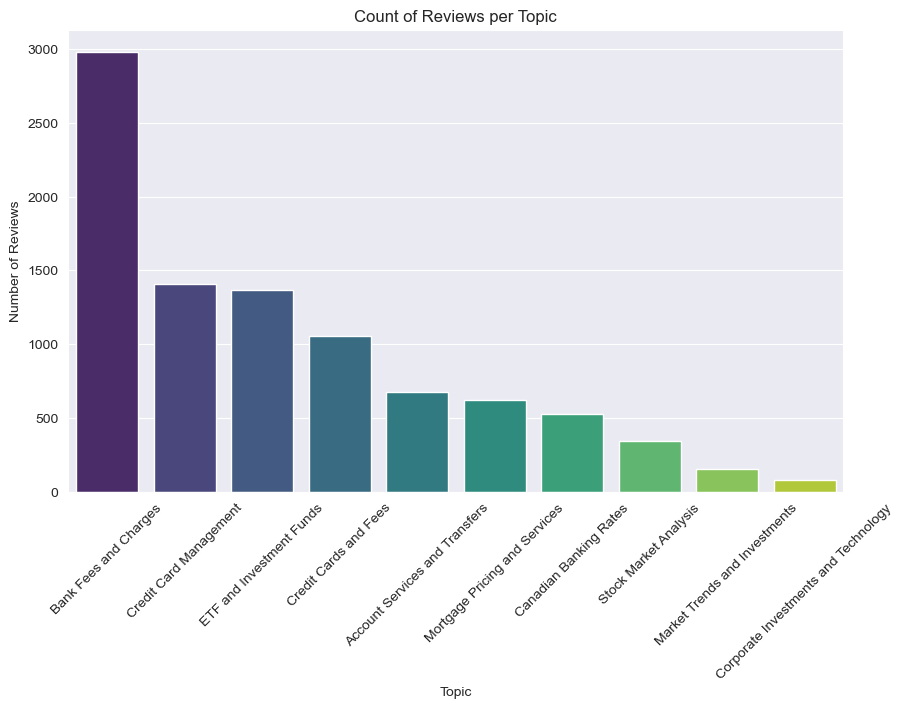

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of reviews for each topic



topic_df = pd.DataFrame(df)  # Convert topic_data into a DataFrame

# Count of reviews for each topic name
topic_counts = topic_df['classified_topic'].value_counts()

# Plotting the count of reviews for each topic name
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title('Count of Reviews per Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()